In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from dataclasses import dataclass, field
from typing import Dict, Tuple, Iterable
from Utils.Plot_Helper import plot_1d_data

In [18]:
def select_data(experiment):
    if experiment == 'ungm':
        exp_table = 'UNGM_EXP'
        con = sqlite3.connect("ungm_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bot':
        exp_table = 'BOT_EXP'
        con = sqlite3.connect("bot_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bott':
        exp_table = 'BOTT_EXP'
        con = sqlite3.connect("bott_final.db", detect_types=sqlite3.PARSE_DECLTYPES)

    cursor = con.cursor()
    return exp_table, cursor


def power_ep_comparison(power_list, damping_list, seed=101, table_name='UNGM_EXP', trans_id='TT', metric='rmse', colors=['C3', 'C2', 'C1']):
    assert metric in ['rmse', 'nll'], 'metric must be one of (rmse, nll)'
    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={} AND Power={} AND Damping={}"
    labels = [r'EP ($\alpha={}, \gamma={}$)', r'EP with damping ($\alpha={}, \gamma={}$)', r'Power EP with damping ($\alpha={}, \gamma={}$']
    ax = None
    for i, params in enumerate(zip(power_list, damping_list)):
        power, damp = params
        data = cursor.execute(query_str.format(metric, table_name, trans_id, seed, power, damp)).fetchall()
        label = labels[i].format(power, damp)
        ax = plot_1d_data(np.array(data).T, label, colors[i], ax=ax)
        
    return ax

Text(0, 0.5, 'RMSE')

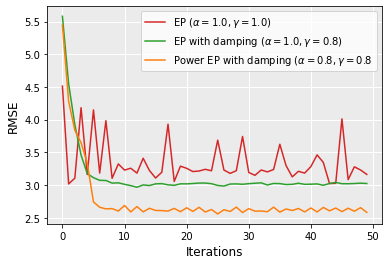

In [26]:
seed = 601
trans = 'MCT'
experiment = 'ungm'
tablename, cursor = select_data(experiment)
power_list = [1.0, 1.0, 0.8]
damping_list = [1.0, 0.8, 0.8]
ax = power_ep_comparison(power_list, damping_list, seed=seed, table_name=tablename, trans_id=trans, metric='rmse')
plt.legend()
ax.set_xlabel("Iterations", fontsize=12)
ax.set_ylabel("RMSE", fontsize=12)

Text(0, 0.5, 'NLL')

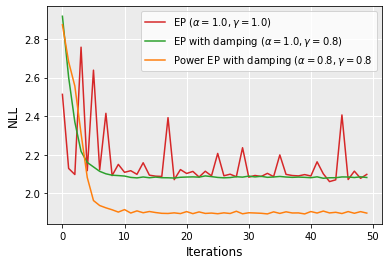

In [27]:
ax = power_ep_comparison(power_list, damping_list, seed=seed, table_name=tablename, trans_id=trans, metric='nll')
plt.legend()
ax.set_xlabel("Iterations", fontsize=12)
ax.set_ylabel("NLL", fontsize=12)

In [62]:
@dataclass
class PlotConfig:
    figsize: Tuple = (12, 5)
    xlabel_fontsize: int = 16
    ylabel_fontsize: int = 16
    title_fontsize: int = 16
    legend_fontsize: int = 12
    xticks: Iterable = None
    xtick_labels: Iterable = None
    xtick_labelsize: int = 16
    yticks: Iterable = None
    ytick_labels: Iterable = None
    ytick_labelsize: int = 16
    vmin_rmse: float = None
    vmax_rmse: float = None
    vmin_nll: float = None
    vmax_nll: float = None


@dataclass
class ExpConfig:
    Seeds: Iterable
    exp_tablename : str
    cursor: sqlite3.Cursor


def _split_variables(control_vars):
    """ Split variables (Power, Damping, Iter) into a control set (fixed during plot) and a dependent set
    """
    control_varnames = list(control_vars.keys())
    control_vardata = []
    for key in control_varnames:
        control_vardata.append(control_vars[key])
    
    vars = ['Power', 'Damping', 'Iter']
    for key in control_varnames:
        assert key in vars, 'Control variable must be one of (Power, Damping, Iter)'

    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={}"
    for var in control_varnames:
        query_str = query_str + f" AND {var}"
        if var == 'Transform':
            query_str = query_str + "='{}'"
        else:
             query_str = query_str + "={}"
        vars.remove(var)

    dependent_varnames = vars

    return control_varnames, dependent_varnames, control_vardata, query_str
    

def plot_experiment(
        control_vars: Dict, metric: str,
        plot_config: PlotConfig, exp_config: ExpConfig, ax=None,
        trans_types=['TT', 'UT', 'MCT'], colors=['C3', 'C2', 'C0'],
        power_display_name='Power', damping_display_name='Damping', iter_display_name='Iteration',
        title=True, xlabel=True, ylabel=True, legend=True
        ):
    assert metric in ['rmse', 'nll'], 'metric must be one of (rsme, nll)'
    assert len(trans_types) == len(colors), 'Number of transformation types and colors must match'

    # Get data and variable names (e.g. Power and Damping)
    control_varnames, dependent_varname, control_vardata, query_str = _split_variables(control_vars)
    assert len(control_varnames) == 2, 'Must specify two control variables'
    data1, data2 = control_vardata[0][0], control_vardata[1][0]
    key1, key2 = control_varnames
    key3 = dependent_varname[0]
    labels = {'Power': power_display_name, 'Damping': damping_display_name, 'Iter': iter_display_name}

    Seeds, exp_table, cursor = exp_config.Seeds, exp_config.exp_tablename, exp_config.cursor
    if Seeds is None:
        Seeds = cursor.fetchall()
        Seeds = [seed[0] for seed in Seeds]

    # Create figure
    if ax is None:
        fig = plt.figure(figsize=plot_config.figsize)
        ax = plt.gca()
    ax.set_facecolor('#EBEBEB')
    ax.grid(True, color='w', linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    plt.rcParams['xtick.labelsize'] = plot_config.xtick_labelsize
    plt.rcParams['ytick.labelsize'] = plot_config.ytick_labelsize

    for c, trans_id in zip(colors, trans_types):
        data = []
        for SEED in Seeds:
            row = cursor.execute(query_str.format(metric, exp_table, trans_id, int(SEED), data1, data2)).fetchall()
            data.append(np.array(row).squeeze())
        data = np.array(data)

        ax = plot_1d_data(data, label=trans_id, c=c, ax=ax)
    
    # Set title, labels and legend
    if title:
        ax.set_title(f"{labels[key1]}: {data1}, {labels[key2]}: {data2}", fontsize=plot_config.title_fontsize)
    if ylabel:
        if metric == 'rmse':
            ax.set_ylabel("RMSE", fontsize=plot_config.ylabel_fontsize)
        elif metric == 'nll':
            ax.set_ylabel("NLL", fontsize=plot_config.ylabel_fontsize)
    if xlabel:
        ax.set_xlabel(f"{labels[key3]}", fontsize=plot_config.xlabel_fontsize)
    if legend:
        ax.legend(fontsize=plot_config.legend_fontsize, loc='upper right', ncol=3)

    # Format axes (ticks, ticklabels, limits)
    xticks, yticks = plot_config.xticks, plot_config.yticks
    xticklabels, yticklabels = plot_config.xtick_labels, plot_config.ytick_labels
    if xticks is not None: ax.set_xticks(xticks)
    if xticklabels is not None: ax.set_xticklabels(xticklabels)
    if yticks is not None: ax.set_yticks(yticks)
    if yticklabels is not None: ax.set_yticklabels(yticklabels)

    if metric == 'rmse':
        vmin, vmax = plot_config.vmin_rmse, plot_config.vmax_rmse
    elif metric == 'nll':
        vmin, vmax = plot_config.vmin_nll, plot_config.vmax_nll

    ax.set_ylim(vmin, vmax)

    return ax


def plot_multiple_experiments(
        control_vars: Dict, plot_config: PlotConfig, exp_config: ExpConfig,
        trans_types=['TT', 'UT', 'MCT'], colors=['C3', 'C2', 'C0'],
        power_display_name='Power', damping_display_name='Damping', iter_display_name='Iteration',
        ):
    assert len(trans_types) == len(colors), 'Number of transformation types and colors must match'
    control_varnames, dependent_varname, control_vardata, query_str = _split_variables(control_vars)
    assert len(control_varnames) == 2, 'Must specify two control variables'
    data1, data2 = control_vardata
    key1, key2 = control_varnames

    # Plot results
    ncol = len(data1)
    fig, axs = plt.subplots(2, ncol, figsize=plot_config.figsize)
    for i, params in enumerate(zip(data1, data2)):
        param1, param2 = params
        data = {key1: [param1], key2: [param2]}
        kwargs = {'trans_types': trans_types,
                  'colors': colors,
                  'power_display_name': power_display_name,
                  'damping_display_name': damping_display_name,
                  'iter_display_name': iter_display_name,
                  'title': True, 'xlabel': False,
                  'ylabel': False, 'legend': True}
        if i == 0:
            kwargs['ylabel'] = True
        
        rmse_ax = axs[0] if ncol==1 else axs[0,i]
        nll_ax = axs[1] if ncol==1 else axs[1,i]
        plot_experiment(data, 'rmse', plot_config, exp_config, ax=rmse_ax, **kwargs)
        kwargs['xlabel'] = True
        kwargs['title'] = False
        plot_experiment(data, 'nll', plot_config, exp_config, ax=nll_ax, **kwargs)

    plt.tight_layout()

    return fig, axs

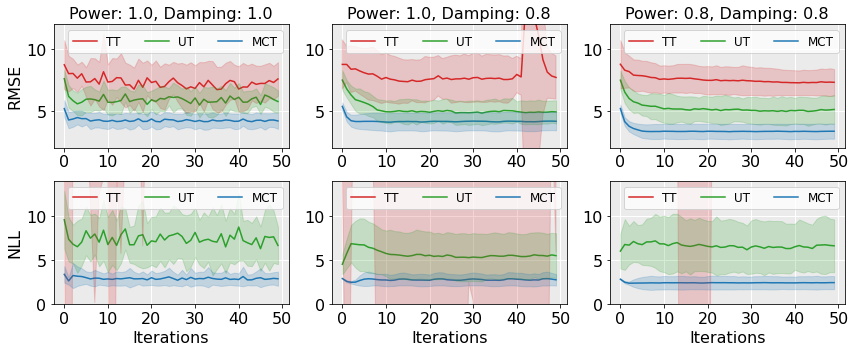

In [63]:
# Plot all experiments
experiment = 'ungm'
tablename, cursor = select_data(experiment)
Seeds = np.arange(101, 1101, 100)
plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=2,
                         vmax_rmse=12,
                         vmin_nll=0,
                         vmax_nll=14)
exp_config = ExpConfig(Seeds=Seeds, exp_tablename=tablename, cursor=cursor)
power_list = [1.0, 1.0, 0.8]
damping_list = [1.0, 0.8, 0.8]
control_vars = {'Power': power_list, 'Damping': damping_list}

fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, iter_display_name='Iterations')

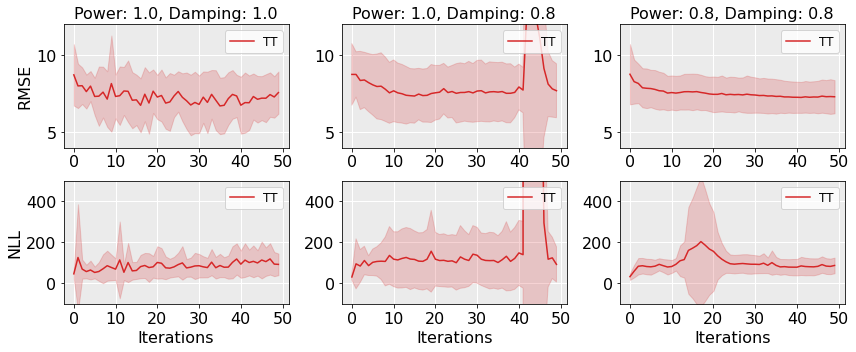

In [64]:
# Plot for Taylor transform only
plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=4, vmax_rmse=12,
                         vmin_nll=-100, vmax_nll=500)
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, trans_types=['TT'], colors=['C3'], iter_display_name='Iterations')

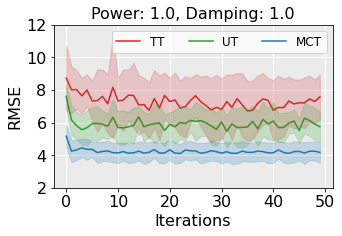

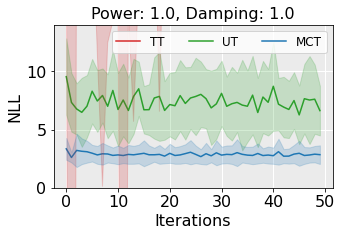

In [45]:
# Plot one window
plot_config = PlotConfig(figsize=(5,3),
                         xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=2, vmax_rmse=12,
                         vmin_nll=0, vmax_nll=14)
control_vars = {'Power': [1.0], 'Damping': [1.0]}
ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, iter_display_name='Iterations')
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, iter_display_name='Iterations')

(-30.0, 1000.0)

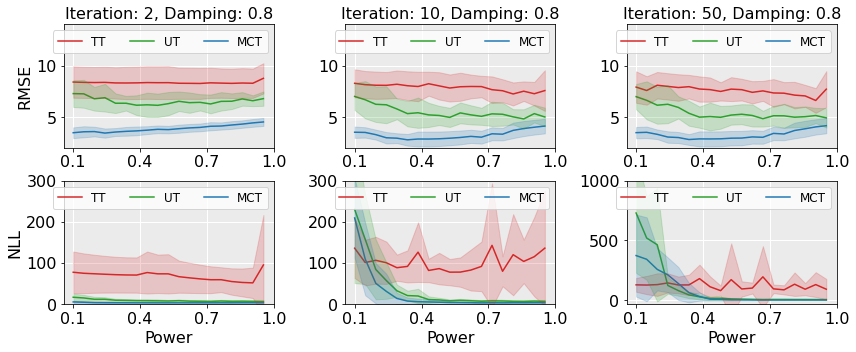

In [65]:
# Plot power sweep for fixed damping rate
experiment = 'ungm'
tablename, cursor = select_data(experiment)
plot_config = PlotConfig(xticks=np.linspace(0, 19, 4),
                         xtick_labels=np.linspace(0.1, 1.0, 4),
                         vmin_rmse=2, vmax_rmse=14,
                         vmin_nll=None, vmax_nll=None)
iter_list = [2, 10, 50]
damping = 0.8
damping_list = [damping for _ in iter_list]
control_vars = {'Iter': iter_list, 'Damping': damping_list}
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config)
axs[1, 0].set_ylim(0, 300)
axs[1, 1].set_ylim(0, 300)
axs[1, 2].set_ylim(-30, 1000)

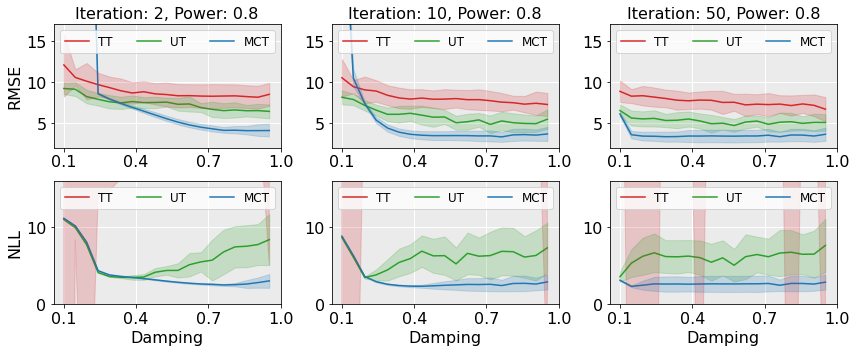

In [69]:
# Plot for fixed power
experiment = 'ungm'
tablename, cursor = select_data(experiment)
plot_config = PlotConfig(xticks=np.linspace(0, 19, 4),
                         xtick_labels=np.linspace(0.1, 1.0, 4),
                         vmin_rmse=2, vmax_rmse=17,
                         vmin_nll=0, vmax_nll=16)
iter_list = [2, 10, 50]
power = 0.8
power_list = [power for _ in iter_list]
control_vars = {'Iter': iter_list, 'Power': power_list}
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config)
# axs[1, 0].set_ylim(0, 300)
# axs[1, 1].set_ylim(0, 300)
# axs[1, 2].set_ylim(-30, 1000)

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import namedtuple

experiment = 'ungm'
exp_table, cursor = select_data(experiment)

# Heat map
methods = [None, 'none','nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

Config = namedtuple('PlotConfig', ['xlabel_kwargs','ylabel_kwargs',
                                        'title_kwargs', 'vmin', 'vmax'])

def plot_power_sweep(config, img, methods, title, ax=None):

    if ax is None:
        ax = plt.gca()

    im = ax.imshow(img, interpolation=methods[4],
                   extent=[0.1,1,0.1,1], cmap='jet',
                   vmax=config.vmax, vmin=config.vmin, origin='lower')

    ax.set_xlabel('Power', **config.xlabel_kwargs)
    ax.set_ylabel('Damping', **config.ylabel_kwargs)
    ax.set_title(title, **config.title_kwargs)
    ax.grid(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.3)
    if config.vmax is not None and config.vmin is not None:
        ticks = np.linspace(0, config.vmax, 6)
        tickslabel = [int(tick) for tick in ticks]
        tickslabel[-1] = f'>{tickslabel[-1]}'
        cbar = plt.colorbar(im, cax=cax, ticks=ticks)
        cbar.ax.set_yticklabels(tickslabel)
    else:
        plt.colorbar(im, cax=cax)
    

def make_image_data(table, transform, seed, iters=10):
    all_iters = """
                    SELECT RMSE, NLL, Power, Damping from 
                    {}
                    WHERE Transform = '{}' AND Seed = {} AND Iter = {}
                """
    cursor.execute(all_iters.format(table, transform, seed, iters))
    data = cursor.fetchall()
    rms, nl, p, d = zip(*data)
    nl = np.array(nl)
    rms = np.array(rms)
    p = np.array(p)
    d = np.array(d)
    p = p.reshape(19, 19)
    d = d.reshape(19, 19)
    p_nll = nl.reshape(19, 19)
    p_rmse = rms.reshape(19, 19)
    
    return p_rmse, p_nll, p, d


def all_seeds_image(table, transform, iters=50, seeds=None):
  all_prmse = []
  all_pnll = []
  cursor.execute(f"SELECT DISTINCT Seed from {table}")
  if seeds is None:
    seeds = cursor.fetchall()
    seeds = [seed[0] for seed in seeds]
  for seed in seeds:
    rmse, nll, p, d = make_image_data(table, transform, seed, iters=iters)
    all_prmse.append(rmse)
    all_pnll.append(nll)
  prmse = np.array(all_prmse)
  pnll = np.array(all_pnll)

  return np.mean(prmse, axis=0), np.mean(pnll, axis=0), p, d


def plot_sweep(config, table, transform, iters=10, kind='rmse', ax=None, seeds=None):
    p_rmse, p_nll, p, d = all_seeds_image(table, transform, iters=iters, seeds=seeds)
    title = f'Transform = {transform}'
    if kind == 'rmse':
        plot_power_sweep(config, (p_rmse.T), methods, title, ax)
    else:
        plot_power_sweep(config, (p_nll.T), methods, title, ax)


def plot_all_transforms(config, table, iters=10, kind='rmse'):
    transform_list = ['TT', 'UT', 'MCT']
    fig, axs = plt.subplots(1, 3, figsize=(26, 9))
    for i, trans in enumerate(transform_list):
        plot_sweep(config, table, trans, iters, kind, axs[i])
    if kind == 'rmse':
        plt.suptitle('RMSE', fontweight='bold', fontsize=30)
    else:
        plt.suptitle('NLL', fontweight='bold', fontsize=30)
    plt.tight_layout()

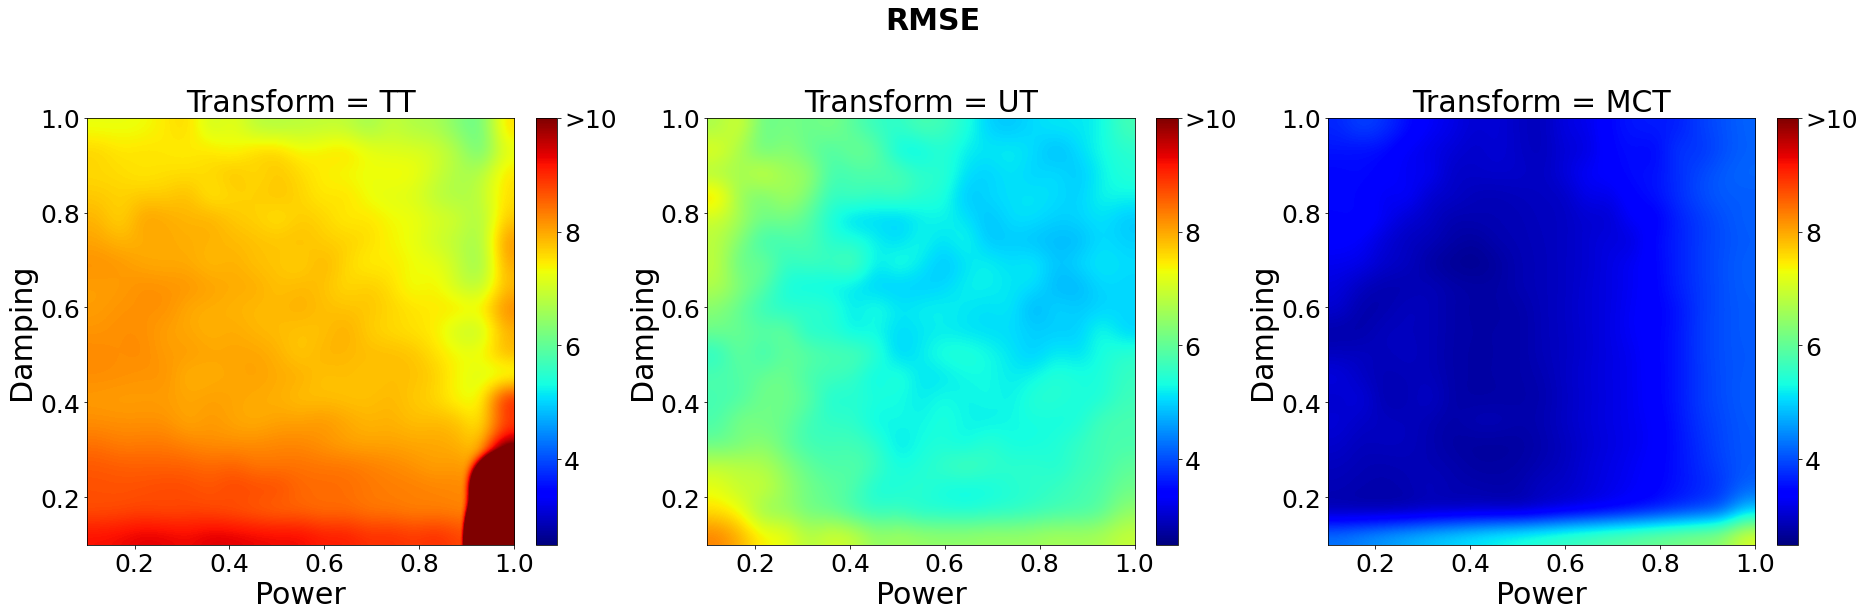

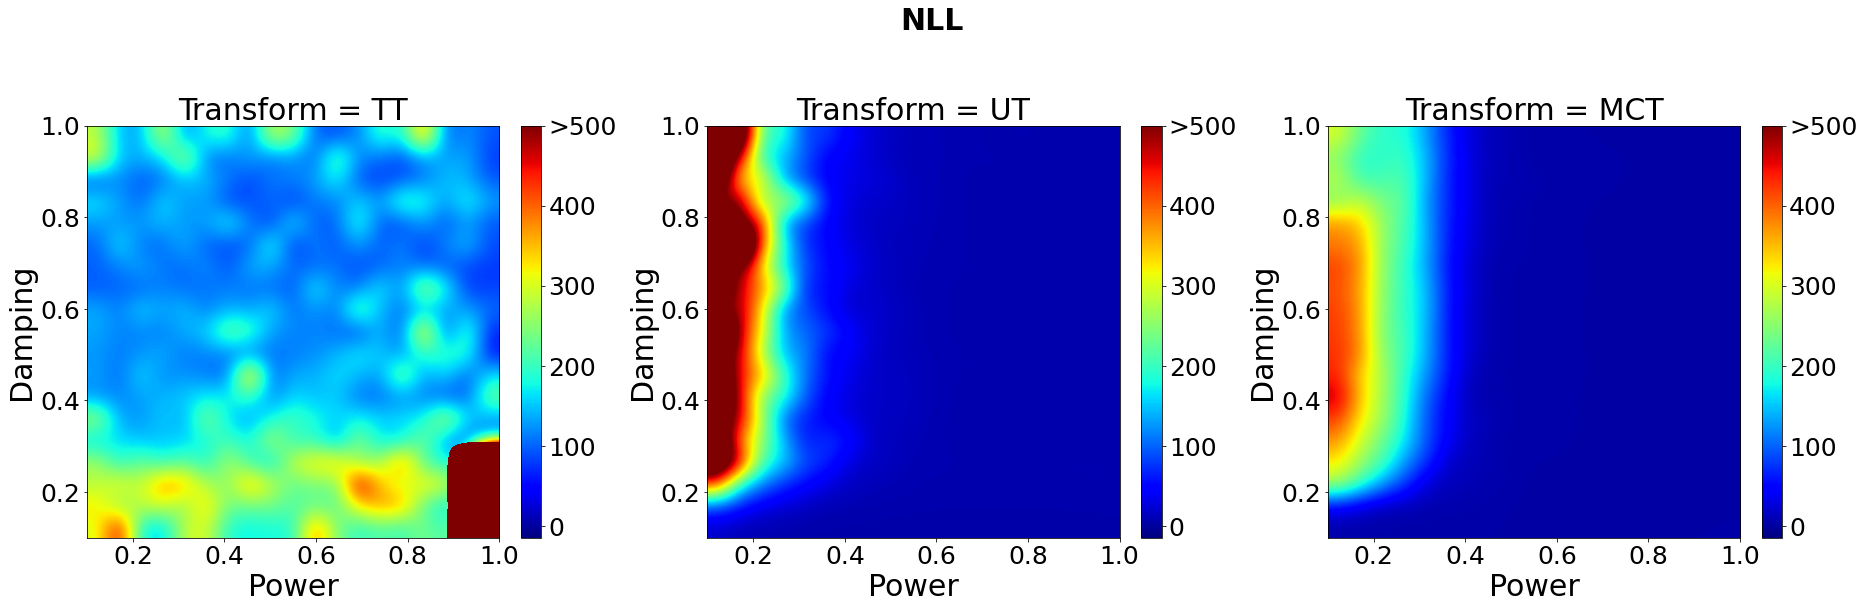

In [54]:
if experiment == 'ungm':
    rmse_vmin = 2.5
    rmse_vmax = 10.0
    nll_vmin = -15.0
    nll_vmax = 500.0
elif experiment == 'bot':
    rmse_vmin = 0.1
    rmse_vmax = 10.0
    nll_vmin = -5.0
    nll_vmax = 1000.0
elif experiment == 'bott':
    rmse_vmin = None
    rmse_vmax = None
    nll_vmin = None
    nll_vmax = None

config = Config(xlabel_kwargs={'fontsize':30},
                ylabel_kwargs={'fontsize':30},
                title_kwargs={'fontsize':30},
                vmin=rmse_vmin, vmax=rmse_vmax)

plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plot_all_transforms(config, exp_table, 50, 'rmse')

config=config._replace(vmin=nll_vmin)
config=config._replace(vmax=nll_vmax)
plot_all_transforms(config, exp_table, 50, 'nll')